# Исследование для оператора связи по удержанию клиентов.

## 1. Описание задачи.

Цель проекта - помочь оператору связи бороться с оттоком клиентов. 

Задача - разработать модель которая сможет определить клиентов, которые планирует отказаться от услуг связи с метрикой AUC-ROC не ниже 0.85

### Описание услуг.

Оператор предоставляет два основных типа услуг: 

- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.нный чек.

## 2. Описание данных.

**Данные состоят из нескольких файлов, полученных из разных источников:**

*contract_new.csv* — информация о договоре
<br>*personal_new.csv* — персональные данные клиента
<br>*internet_new.csv* — информация об интернет-услугах
<br>*phone_new.csv* — информация об услугах телефонии
<br>Во всех файлах столбец *customerID* содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020 года.

**Описание полей данных:**

*BeginDate* — дата начала действия договора,
<br>*EndDate* — дата окончания действия договора,
<br>*Type* — тип оплаты: раз в год-два или ежемесячно,
<br>*PaperlessBilling* — электронный расчётный лист,
<br>*PaymentMethod* — тип платежа,
<br>*MonthlyCharges* — расходы за месяц,
<br>*TotalCharges* — общие расходы абонента,
<br>*gender* — пол,
<br>*SeniorCitizen* — является ли абонент пенсионером
<br>*Partner* — есть ли у абонента супруг или супруга
<br>*Dependents* — есть ли у абонента дети,
<br>*InternetService* — тип подключения,
<br>*OnlineSecurity* — блокировка опасных сайтов,
<br>*OnlineBackup* — облачное хранилище файлов для резервного копирования данных,
<br>*DeviceProtection* — антивирус,
<br>*TechSupport* — выделенная линия технической поддержки,
<br>*StreamingTV* — стриминговое телевидение,
<br>*StreamingMovies* — каталог фильмов,
<br>*MultipleLines* — подключение телефона к нескольким линиям одновременно.

**Предварительный план исследования:**

1. Загрузить и изучить данные. Провести предобработку данных;
2. Объединить датафреймы в один, проверить объединенный датафрейм, изучить распределение признаков;
3. Подготовить данные для обучения моделей: кодирование, разбиение на обучающую и тестовую выборки;
4. Выбрать модели для обучения, подобрать для них гиперпараметры;
5. Провести обучение моделей, выбрать лучшую на основе скорости обучения и метрики AUC-ROC => 0.85;
6. Провести финальнуюю оценку для лучшей модели на тестовой выборке. Сделать анализ лучшей модели (важность признаков, матрица ошибок); 
7. Сделать выводы, указав этапы, что было предпринято, а также показатели лучшей модели, ее качество. 

## 3. Загрузка библиотек и данных.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from functools import reduce

import phik
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, precision_score, recall_score, f1_score, accuracy_score

import time

import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
RANDOM_STATE = rs = 171123
test_size = 0.25

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
try:
    df_contract = pd.read_csv('/datasets/contract_new.csv')
    df_internet = pd.read_csv('/datasets/internet_new.csv')
    df_personal = pd.read_csv('/datasets/personal_new.csv')
    df_phone = pd.read_csv('/datasets/phone_new.csv')
except:
    df_contract = pd.read_csv('c:/Users/User/Downloads/contract_new.csv')
    df_internet = pd.read_csv('c:/Users/User/Downloads/internet_new.csv')
    df_personal = pd.read_csv('c:/Users/User/Downloads/personal_new.csv')
    df_phone = pd.read_csv('c:/Users/User/Downloads/phone_new.csv')

Общая информация о данных.

In [5]:
for df in (df_contract, df_personal, df_internet, df_phone):
    df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   D

In [6]:
for df in (df_contract, df_personal, df_internet, df_phone):
    display(df.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [7]:
for df in (df_contract, df_personal, df_internet, df_phone):
    display(df.describe())

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


In [8]:
for df in (df_contract, df_personal, df_internet, df_phone):
    display(df.duplicated().sum())

0

0

0

0

In [9]:
for df in (df_contract, df_personal, df_internet, df_phone):
    display(df.describe(include='object'))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043
unique,7043,77,67,3,2,4,6658
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,
freq,1,366,5942,3875,4171,2365,11


,customerID,gender,Partner,Dependents
count,7043,7043,7043,7043
unique,7043,2,2,2
top,7590-VHVEG,Male,No,No
freq,1,3555,3641,4933


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


**Выводы:**
1. Имеется 4 файла с данными (df_contract, df_personal, df_internet, df_phone) с 7043, 7043, 5517, 6361 строками в каждом соответственно. 
2. В данных нет пропущенных значений, но они могут появиться после конкатенации (присоединения) таблиц.
3. Нужно провести незначительную предобработку: изменение типа данных, привести назнания столбцов к змеиному регистру.

## 4. Предварительная обработка данных

Объединим таблицы по полю *customerID* и приведём название столбцов к змеиному регистру.

In [10]:
df_list = [df_contract, df_personal, df_internet, df_phone]
df_concated = reduce(lambda left,right: pd.merge(left,right,on='customerID', how='outer'), df_list)
df_concated.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower()for i in df_concated.columns]
df_concated.drop(['customer_i_d'], axis=1, inplace=True)

In [11]:
display(df_concated.head())
display(df_concated.info())

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
0,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   begin_date         7043 non-null   object 
 1   end_date           7043 non-null   object 
 2   type               7043 non-null   object 
 3   paperless_billing  7043 non-null   object 
 4   payment_method     7043 non-null   object 
 5   monthly_charges    7043 non-null   float64
 6   total_charges      7043 non-null   object 
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   int64  
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  internet_service   5517 non-null   object 
 12  online_security    5517 non-null   object 
 13  online_backup      5517 non-null   object 
 14  device_protection  5517 non-null   object 
 15  tech_support       5517 non-null   object 
 16  streaming_t_v      5517 

None

In [12]:
df_concated['end_date'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

In [13]:
df_concated.loc[df_concated['end_date']=='No','end_date'].count()

5942

In [14]:
df_concated['former_client'] = (df_concated['end_date'] != 'No').astype(int)
df_concated['former_client'].unique()

array([0, 1])

In [15]:
df_concated.sample(10)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,former_client
3769,2016-10-01,No,Month-to-month,Yes,Electronic check,26.20,1068.96,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0
18,2019-01-01,No,Month-to-month,No,Credit card (automatic),55.20,789.36,Female,0,Yes,Yes,DSL,No,No,Yes,Yes,No,No,No,0
1599,2014-04-01,No,Two year,Yes,Bank transfer (automatic),80.40,6134.52,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,Yes,No,0
5401,2017-07-01,No,Two year,No,Mailed check,20.45,633.95,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
958,2018-01-01,No,Month-to-month,No,Bank transfer (automatic),81.75,2043.75,Male,0,No,No,DSL,Yes,Yes,Yes,Yes,No,Yes,Yes,0
5110,2019-06-01,No,Month-to-month,Yes,Electronic check,73.50,635.04,Female,0,No,No,Fiber optic,No,No,No,No,No,No,Yes,0
290,2017-11-01,No,Month-to-month,Yes,Electronic check,76.10,2260.17,Male,1,No,No,Fiber optic,No,No,No,No,No,No,Yes,0
6140,2019-11-01,No,Month-to-month,No,Mailed check,19.95,60.45,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
6117,2014-05-01,No,Two year,Yes,Bank transfer (automatic),19.30,1438.24,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
6096,2020-01-01,No,Month-to-month,Yes,Electronic check,70.20,70.2,Female,1,No,No,Fiber optic,No,No,No,No,No,No,No,0


Измененим тип данных в некоторых столбцах и заменим значения столбца *end_date* датой выгрузки.

In [16]:
df_concated.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,former_client
0,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,0
1,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0
2,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0
3,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,0
4,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0


In [17]:
df_concated['end_date'] = df_concated['end_date'].where(df_concated['end_date'] != 'No', '2020-02-01')
df_concated['end_date'] = pd.to_datetime(df_concated['end_date'])

Со столбцом *total_charges* возникла проблема, решим как заполнить пропуски.

In [18]:
df_concated.query('total_charges ==  " "')

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,former_client
488,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN,0
753,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
936,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0
1082,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0
1340,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN,0
3331,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
3826,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0
4380,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
5218,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
6670,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0


Всё стало понятно, что количество не установлено для новых пользователей, которые стали клиентами в день выгрузки данных. Поэтому вместо пропусков поставим ноль, а затем переведем весь столбец в *float*.

In [19]:
df_concated.loc[df_concated['total_charges'] == " ", 'total_charges'] = 0
df_concated['total_charges'] = df_concated['total_charges'].astype(float)

Посчитаем цикл жизни клиента, это - разница значений столбцов *end_date* и *begin_date*.

In [20]:
df_concated['begin_date'] = pd.to_datetime(df_concated['begin_date'], format='%Y-%m-%d')

In [21]:
df_concated['life_cycle'] = (df_concated['end_date'] - df_concated['begin_date']).dt.days

In [22]:
df_concated = df_concated.drop(['begin_date', 'end_date'], axis=1)

В получившемся датасете большая часть признаков отображена бинарными признаками *Yes, No*. Их заменим на *1* и *0*, чтобы привести к типу *int*.

In [23]:
df_concated = df_concated.fillna('No')

In [24]:
for col in ['paperless_billing', 'partner', 'dependents', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies', 'multiple_lines']:
    df_concated[col] = (df_concated[col] == 'Yes').astype('int64')

In [25]:
display(df_concated.head())
display(df_concated.info())

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,former_client,life_cycle
0,Month-to-month,1,Electronic check,29.85,31.04,Female,0,1,0,DSL,0,1,0,0,0,0,0,0,31
1,One year,0,Mailed check,56.95,2071.84,Male,0,0,0,DSL,1,0,1,0,0,0,0,0,1036
2,Month-to-month,1,Mailed check,53.85,226.17,Male,0,0,0,DSL,1,1,0,0,0,0,0,0,123
3,One year,0,Bank transfer (automatic),42.30,1960.60,Male,0,0,0,DSL,1,0,1,1,0,0,0,0,1371
4,Month-to-month,1,Electronic check,70.70,353.50,Female,0,0,0,Fiber optic,0,0,0,0,0,0,0,0,153


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   int64  
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   gender             7043 non-null   object 
 6   senior_citizen     7043 non-null   int64  
 7   partner            7043 non-null   int64  
 8   dependents         7043 non-null   int64  
 9   internet_service   7043 non-null   object 
 10  online_security    7043 non-null   int64  
 11  online_backup      7043 non-null   int64  
 12  device_protection  7043 non-null   int64  
 13  tech_support       7043 non-null   int64  
 14  streaming_t_v      7043 non-null   int64  
 15  streaming_movies   7043 non-null   int64  
 16  multiple_lines     7043 

None

In [26]:
df_concated.duplicated().sum()

4

In [27]:
df_concated = df_concated.drop_duplicates()

In [28]:
df_concated.duplicated().sum()

0

**Вывод:**
Объедены таблицы, преобразованы данные в нужный формат, удалены дубликаты и заполнены значения NaN.

## 5. Исследовательский анализ и предобработка данных объединённого датафрейма.

Посмотрим на гистограммы для числовых столбцов.

Цикл жизни клиентов.

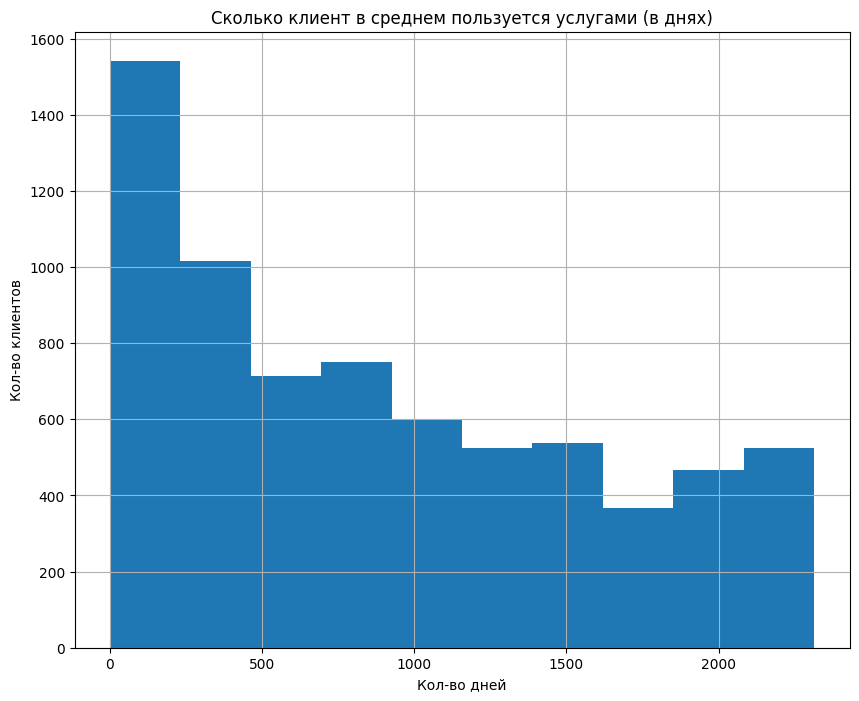

In [29]:
df_concated['life_cycle'].plot(kind='hist', subplots=True,  figsize=(10, 8), grid = True);
plt.title('Сколько клиент в среднем пользуется услугами (в днях)')
plt.xlabel("Кол-во дней")
plt.ylabel("Кол-во клиентов");

In [30]:
df_concated['life_cycle'].describe()

count    7039.000000
mean      898.435005
std       682.820576
min         0.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: life_cycle, dtype: float64

В среднем клиенты пользуются услугами около 2 лет. Сравним клиентов по ежемесячным платежам.

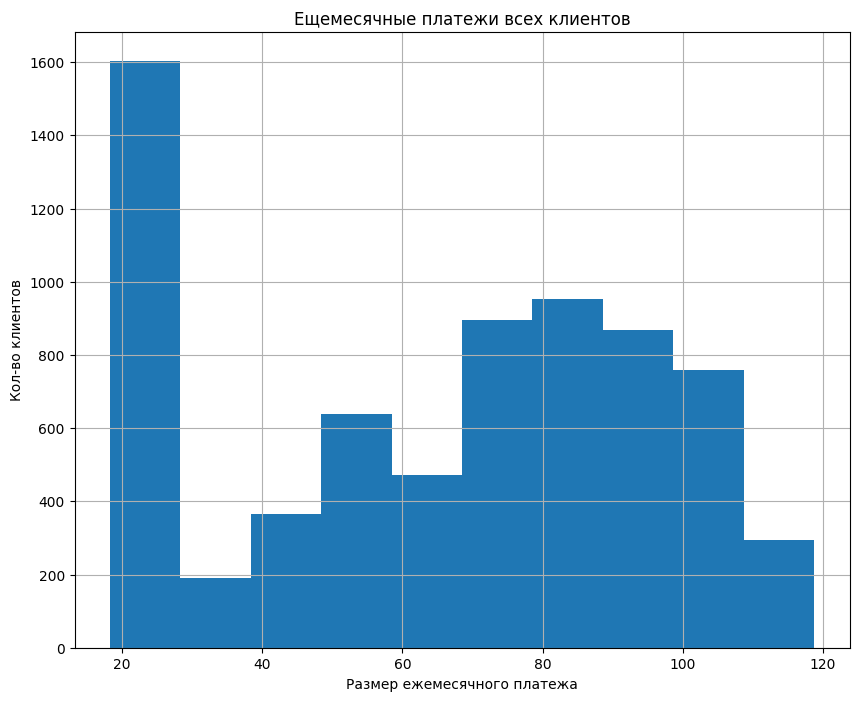

In [31]:
df_concated['monthly_charges'].plot(kind='hist', subplots=True,  figsize=(10, 8), grid = True)
plt.title('Ещемесячные платежи всех клиентов')
plt.ylabel('Кол-во клиентов')
plt.xlabel('Размер ежемесячного платежа')
plt.show()

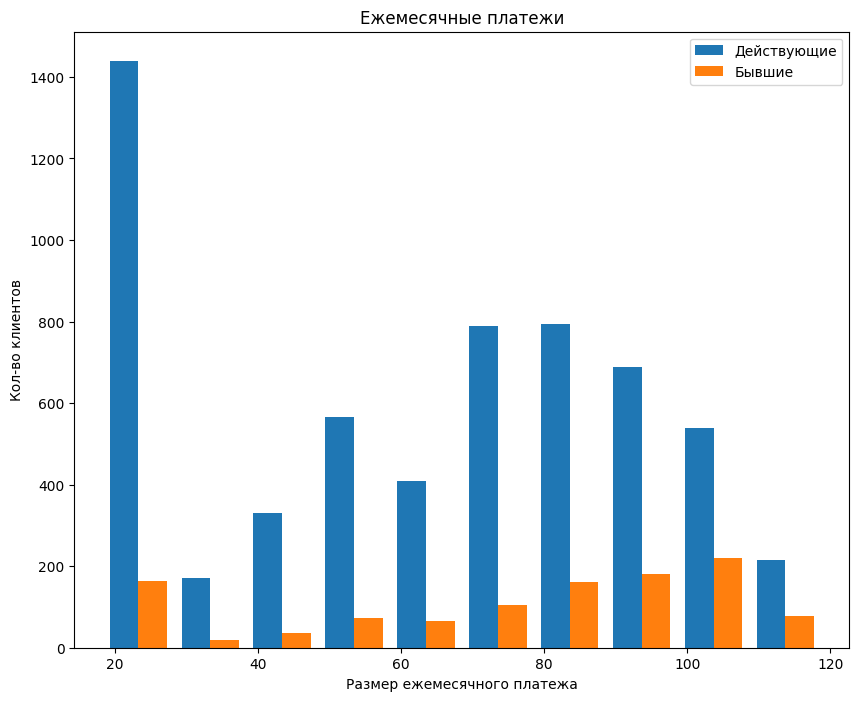

In [32]:
plt.figure(figsize=[10,8])
df = [df_concated[df_concated.former_client == 0].monthly_charges,
          df_concated[df_concated.former_client == 1].monthly_charges]
plt.hist(df)
plt.legend(['Действующие', 'Бывшие'])
plt.title('Ежемесячные платежи')
plt.ylabel('Кол-во клиентов')
plt.xlabel('Размер ежемесячного платежа')
plt.show()

На гистограммах видно, что у большинства клиентов размер ежемесячного платежа ниже 40, то есть и самый популярный. Также можно отметить, что большинство ушедних клиентов платили больше 60 в месяц.

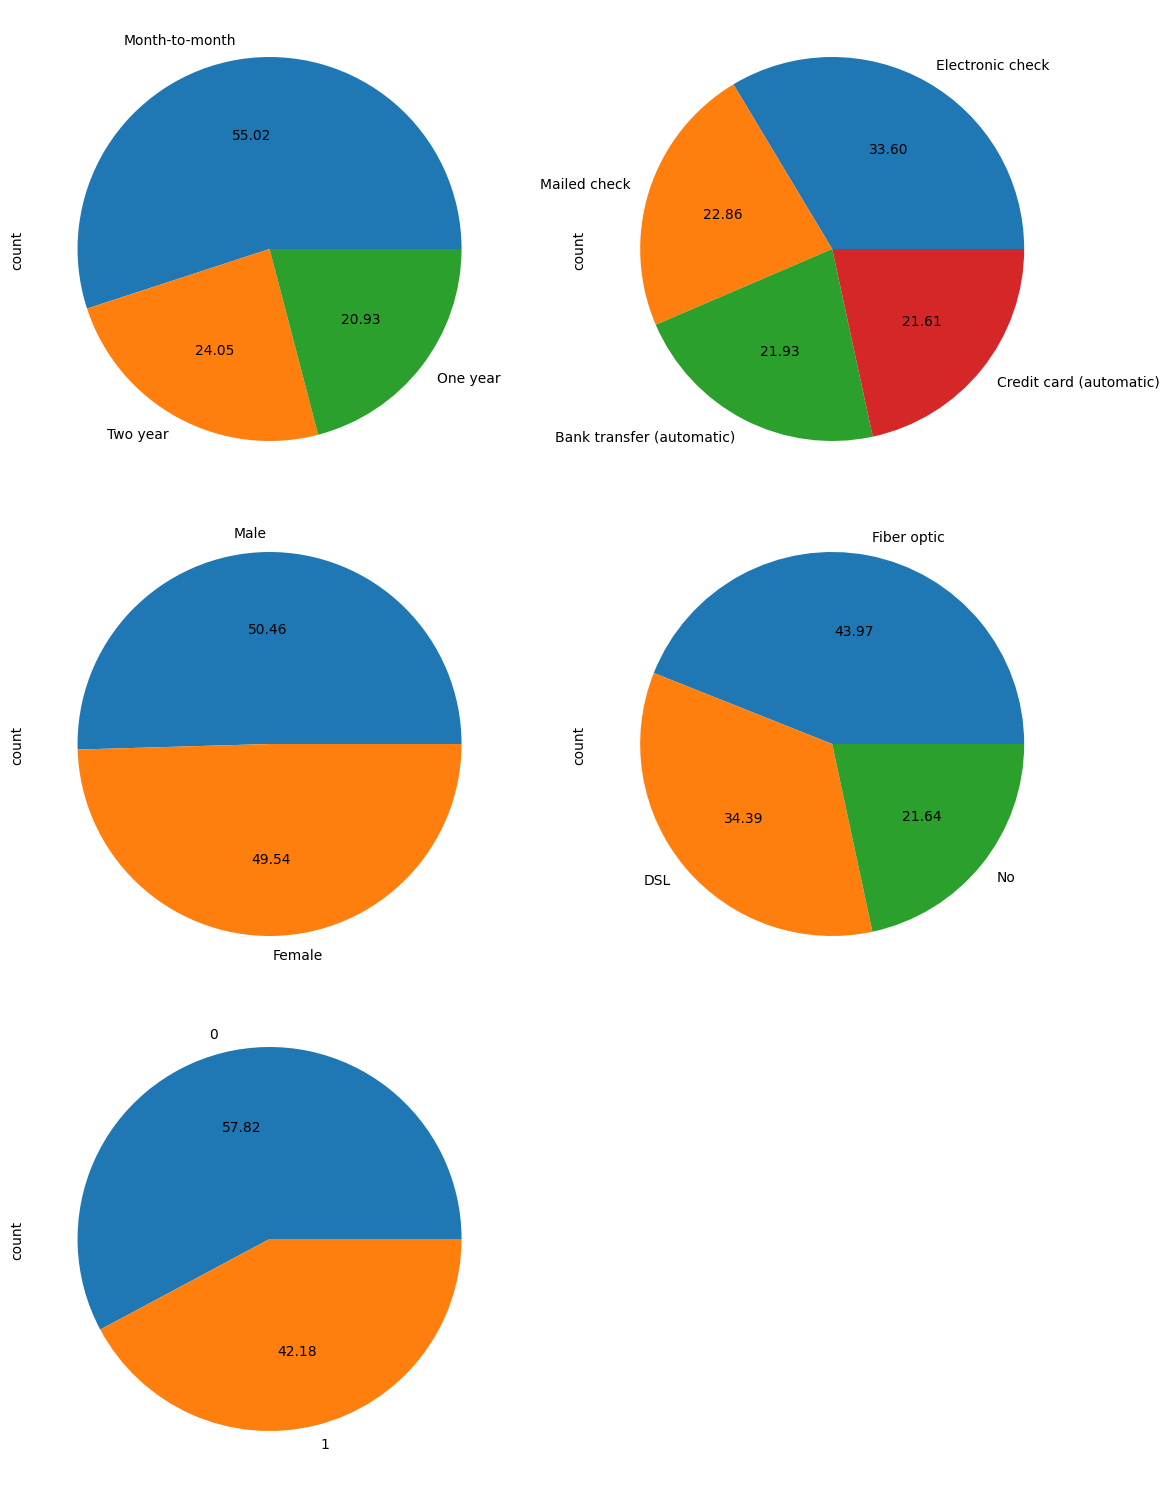

In [33]:
f, axes = plt.subplots(3, 2, figsize=(12, 15))
f.delaxes(axes[2,1])
df_concated['type'].value_counts().plot.pie(autopct='%.2f', ax=axes[0, 0]);
df_concated['payment_method'].value_counts().plot.pie(autopct='%.2f', ax=axes[0, 1]);
df_concated['gender'].value_counts().plot.pie(autopct='%.2f', ax=axes[1, 0]);
df_concated['internet_service'].value_counts().plot.pie(autopct='%.2f', ax=axes[1, 1]);
df_concated['multiple_lines'].value_counts().plot.pie(autopct='%.2f', ax=axes[2, 0]);
f.tight_layout()

Из графиков выше видны следующие наблюдения:
- 55% пользователей используют ежемесячную оплату.
- Большинство пользователей используют оптоволоконный интернет.
- Около 22 % пользователей компании не пользуются интернетом (только телефоном)
- Около 10% людей вообще не пользуются телефоном

И закончим целевым признаком.

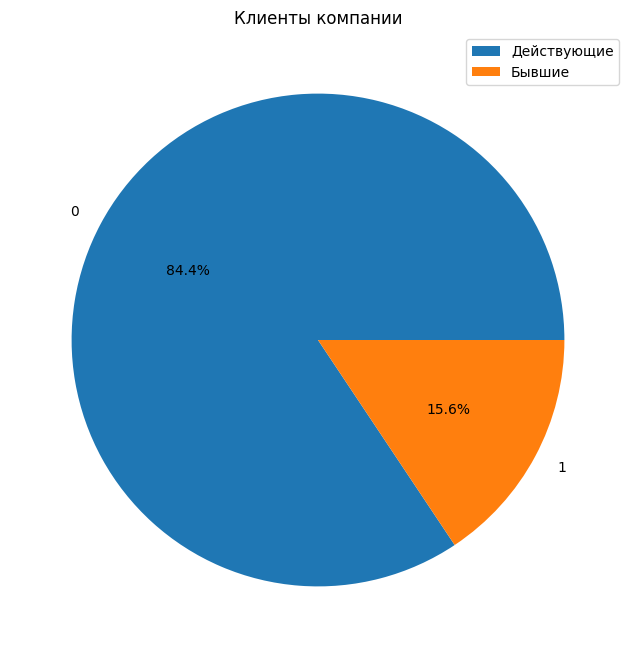

In [34]:
df = df_concated.groupby('former_client').size()
df.plot(kind='pie', subplots=True, autopct='%1.1f%%', figsize=(8, 8))
plt.legend(['Действующие', 'Бывшие'])
plt.title('Клиенты компании')
plt.ylabel('')
plt.show()

Около 16 % клиентов покинули компанию за все время. Осталось рассмотреть корреляцию.

In [35]:
interval_columns = ['monthly_charges','total_charges','life_cycle']

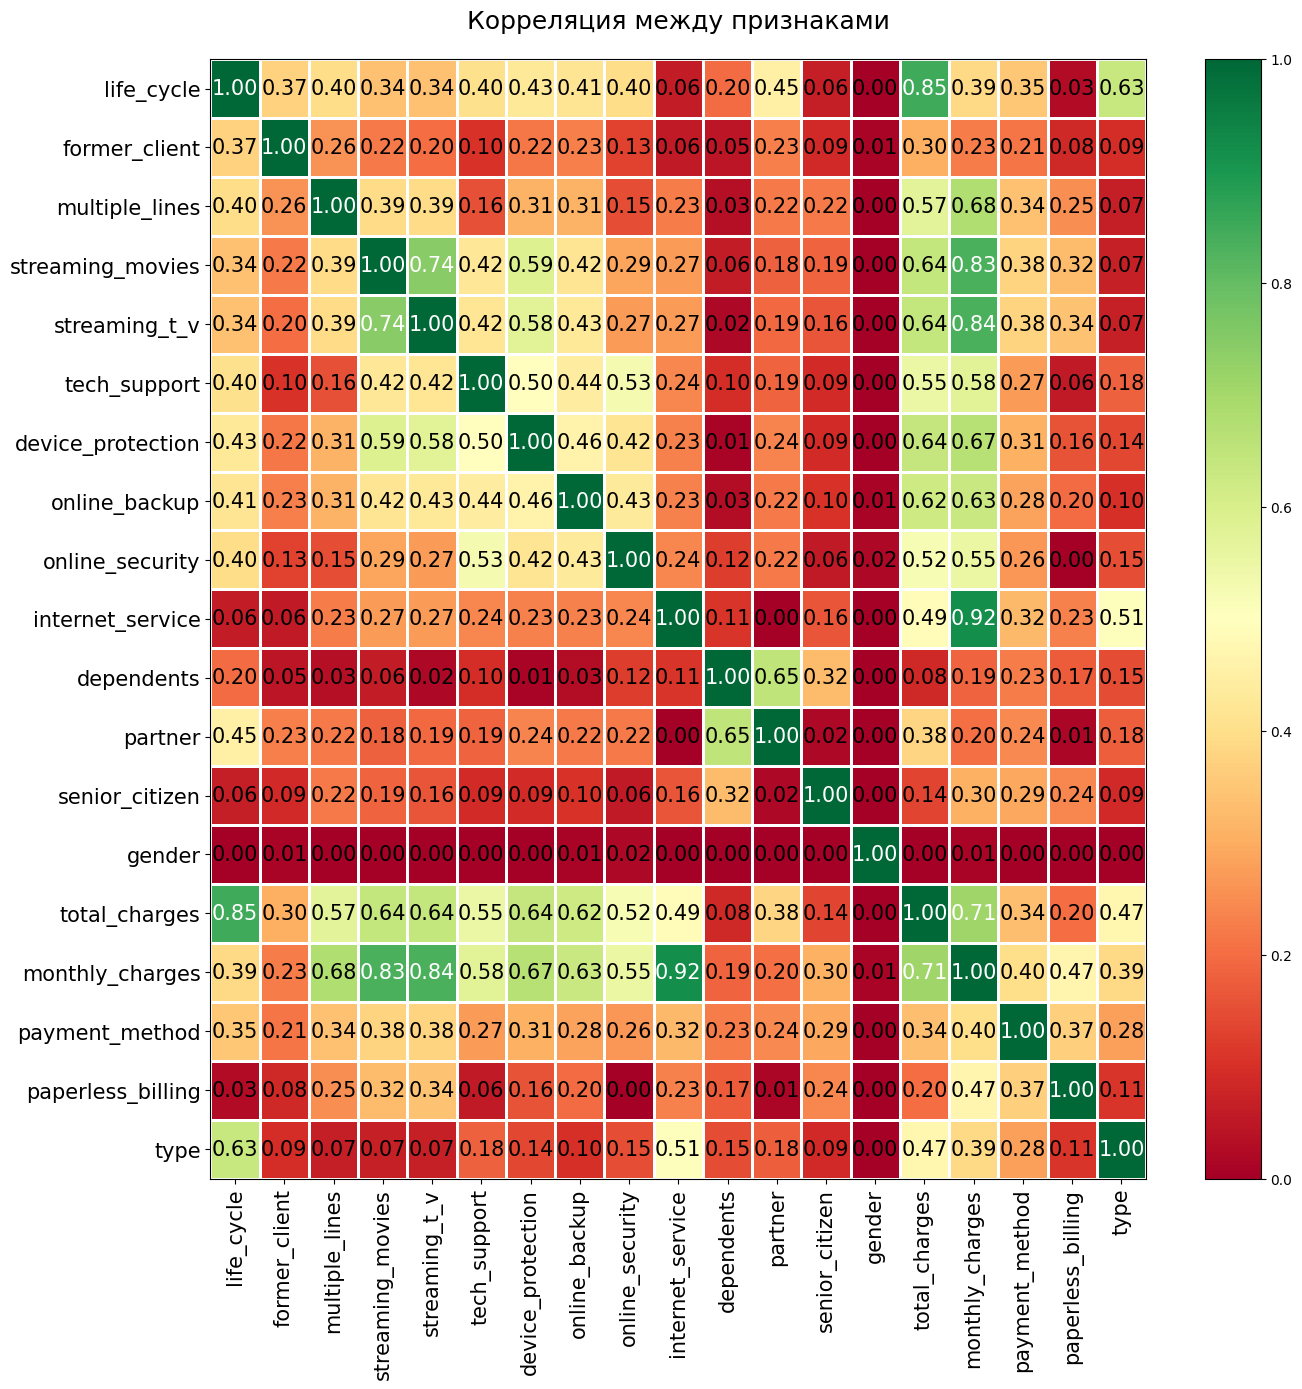

In [36]:
phik_overview = df_concated.phik_matrix(interval_cols=interval_columns)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, 
                        fontsize_factor=1.5, 
                        figsize=(14, 14))
plt.title('Корреляция между признаками', fontsize=18, y=1.02)
plt.tight_layout()

Можно заключить следующее по построенной тепловой карте, что есть высокая взаимосвязь также между продолжительностью пользования услугами и общей суммой платежа. Логично, поскольку чем больше клиент в компании, тем больше денег он оставил независимо от размера ещемесячного платежа.

Возможно признак *total_charges* уберем в дальнейшем, если придется использовать линейные модели. Т.к. мультиколлинеарность влияет на алгоритмы линейных моделей.

**Выводы:**
1. Расмотрены данные в графическом формате.
2. Рассмотрена корреляция между признаками, сделаны по ним выводы.
3. Выявлено, что данные несбалансированы в целевом признаке, что будет учтено в исследовании задачи.

## 6. Подготовка данных.

Поскольку нам предстоит решить задачу классификации, то в исследовании будут использованы следующие модели:

- Решающее дерево;
- Случайный лес;
- Catboost.

Данные будут разделены на две выборки без валидационной, так как данных мало.

Проведем кодировку данных, масштабирование в зависимости от модели для их корректного обучения.

Для поиска лучших параметров воспользуемся GridSearchCV, затем выберем лучшую модель для проверки на тестовой выборке.

Необходимо достичь AUC-ROC >= 0.85

Разобьем данные на обучающую и тестовую по принципу 75%/25% с использованием дефолтных значений.

In [37]:
target = df_concated['former_client']
features = df_concated.drop('former_client', axis=1)

features_train,features_test, target_train,target_test = train_test_split(features, target, test_size=test_size, random_state=rs, stratify=target)

In [38]:
print('Размер целевого признака для обучения и теста:', target_train.shape, target_test.shape)
print('Размер общих признаков для обучения и теста:', features_train.shape, features_test.shape)

Размер целевого признака для обучения и теста: (5279,) (1760,)
Размер общих признаков для обучения и теста: (5279, 18) (1760, 18)


Закодируем данные, для этого используем функцию OrdinalEncoder. Выделим категориальные признаки из датасета.

In [39]:
df_concated.sample()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,former_client,life_cycle
6916,Two year,0,Bank transfer (automatic),19.55,886.01,Male,0,0,1,No,0,0,0,0,0,0,0,0,1340


In [40]:
categorical = ['type', 'payment_method', 'gender', 'internet_service']

In [41]:
def oe_fun(features_train, features_test):
    encoder = OrdinalEncoder()
    encoder.fit(features_train[categorical])
    
    oe_f_train = (
        pd.DataFrame(encoder.transform(features_train[categorical]), 
                     columns=categorical, index=features_train.index).
        merge(features_train.drop(categorical, axis=1), left_index=True, right_index=True)
    )
    
    oe_f_test = (
        pd.DataFrame(encoder.transform(features_test[categorical]), 
                     columns=categorical, index=features_test.index)
        .merge(features_test.drop(categorical, axis=1), left_index=True, right_index=True)
    )
    
    return oe_f_train, oe_f_test

In [42]:
oe_features_train, oe_features_test = oe_fun(features_train, features_test)

In [43]:
display(oe_features_train.sample(5))
display(oe_features_test.sample(5))

,type,payment_method,gender,internet_service,paperless_billing,monthly_charges,total_charges,senior_citizen,partner,dependents,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,life_cycle
3033,2.0,0.0,0.0,1.0,1,110.80,7534.40,0,1,0,1,1,1,0,1,1,1,2071
153,2.0,2.0,1.0,0.0,0,86.10,4289.50,0,1,1,1,1,1,1,1,1,0,1431
1273,0.0,2.0,1.0,1.0,1,88.20,3333.96,1,1,0,1,1,1,0,0,0,1,1096
1432,0.0,0.0,1.0,2.0,0,20.75,769.83,0,0,0,0,0,0,0,0,0,0,1067
4462,0.0,2.0,0.0,1.0,1,88.45,1680.55,0,0,0,0,0,1,0,0,1,1,580


,type,payment_method,gender,internet_service,paperless_billing,monthly_charges,total_charges,senior_citizen,partner,dependents,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,life_cycle
3523,2.0,1.0,0.0,1.0,0,112.10,8151.91,0,1,0,1,1,1,1,1,1,1,2191
3855,0.0,1.0,1.0,0.0,0,65.00,3479.45,0,1,1,0,1,0,1,1,0,0,1614
5902,0.0,3.0,0.0,0.0,0,50.85,471.38,0,1,0,0,1,0,0,0,0,0,276
1849,0.0,2.0,1.0,0.0,1,45.55,552.07,0,0,0,0,0,0,0,0,0,0,365
755,0.0,2.0,1.0,1.0,1,98.55,1015.07,1,0,0,0,0,1,0,1,1,1,306


**Вывод:**
1. На данном этапе данные были разделены на тренировочную и тестовую, затем закодированы.
2. Для обучения были выбраны: решающее дерево, случайный лес, сatboost.

## 7. Обучение моделей машинного обучения.

Воспользуемся GridSearchCV для поиска лучших параметров. Выберем из получившихся моделей лучшую.

**Дерево решений:**

In [44]:
%%time

cv = 5
params_dt = {'max_depth': range(1, 8),
              'min_samples_leaf' : range (1,6),
              'max_features' : range(1,7)
            }

dt = DecisionTreeClassifier(random_state=rs)

dt_grid = GridSearchCV(dt, cv=cv, scoring='roc_auc', param_grid=params_dt,verbose=1)
dt_grid.fit(oe_features_train, target_train)

print('Лучший ROC-AUC на тренировочной выборке:', dt_grid.best_score_)
print('Лучшие параметры модели на тренировочной выборке:', dt_grid.best_params_)

Fitting 5 folds for each of 210 candidates, totalling 1050 fits
Лучший ROC-AUC на тренировочной выборке: 0.7760128024056137
Лучшие параметры модели на тренировочной выборке: {'max_depth': 6, 'max_features': 6, 'min_samples_leaf': 2}
CPU times: total: 9.73 s
Wall time: 9.81 s


**Случайный лес:**

In [45]:
%%time

cv = 3
params_rf = {'max_depth': [15, 20], 
              'n_estimators': [100, 500],
              'criterion': ['gini', 'entropy'], 
              'class_weight': ['balanced']
         }

rf = RandomForestClassifier(random_state=rs)

rf_grid = GridSearchCV(rf, cv=cv, scoring='roc_auc', param_grid=params_rf, verbose=1)
rf_grid.fit(oe_features_train, target_train)

print('Лучший ROC-AUC на тренировочной выборке:', rf_grid.best_score_)
print('Лучшие параметры модели на тренировочной выборке:', rf_grid.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Лучший ROC-AUC на тренировочной выборке: 0.8168469518993421
Лучшие параметры модели на тренировочной выборке: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 500}
CPU times: total: 1min 4s
Wall time: 1min 5s


**Catboost:**

In [46]:
%%time

cv = 5
params_cb = {'max_depth': [1, 2], 
              'n_estimators': [1000, 2000],
             'learning_rate': [0.1],
              'border_count': [128]
            }

cb = CatBoostClassifier(random_state=rs, eval_metric='AUC', loss_function='Logloss')

cb_grid = GridSearchCV(cb, cv=cv, scoring='roc_auc', param_grid=params_cb)
cb_grid.fit(oe_features_train, target_train)

print('Лучший ROC-AUC на тренировочной выборке:', cb_grid.best_score_)
print('Лучшие параметры модели на тренировочной выборке:', cb_grid.best_params_)

0:	total: 62.5ms	remaining: 1m 2s
1:	total: 64.1ms	remaining: 32s
2:	total: 65.8ms	remaining: 21.9s
3:	total: 67.3ms	remaining: 16.8s
4:	total: 69.1ms	remaining: 13.7s
5:	total: 70.6ms	remaining: 11.7s
6:	total: 72.2ms	remaining: 10.2s
7:	total: 73.7ms	remaining: 9.14s
8:	total: 75.3ms	remaining: 8.29s
9:	total: 76.9ms	remaining: 7.61s
10:	total: 78.6ms	remaining: 7.07s
11:	total: 80.2ms	remaining: 6.6s
12:	total: 81.8ms	remaining: 6.21s
13:	total: 83.5ms	remaining: 5.88s
14:	total: 85.1ms	remaining: 5.59s
15:	total: 86.6ms	remaining: 5.33s
16:	total: 88.2ms	remaining: 5.1s
17:	total: 90.2ms	remaining: 4.92s
18:	total: 92.2ms	remaining: 4.76s
19:	total: 94.1ms	remaining: 4.61s
20:	total: 96.3ms	remaining: 4.49s
21:	total: 98ms	remaining: 4.36s
22:	total: 100ms	remaining: 4.25s
23:	total: 102ms	remaining: 4.13s
24:	total: 104ms	remaining: 4.04s
25:	total: 106ms	remaining: 3.96s
26:	total: 107ms	remaining: 3.87s
27:	total: 109ms	remaining: 3.8s
28:	total: 111ms	remaining: 3.71s
29:	total

In [47]:
auc_table = pd.DataFrame({'Модель': ['DecisionTreeClassifier','RandomForestClassifier', 'CatBoostClassifier'],
                      'Результат ROC-AUC':[0.77, 0.82, 0.92],
                       'Время обучения':['9.66 s', '1min 7s', '1min 4s']}
                        )
auc_table

,Модель,Результат ROC-AUC,Время обучения
0,DecisionTreeClassifier,0.77,9.66 s
1,RandomForestClassifier,0.82,1min 7s
2,CatBoostClassifier,0.92,1min 4s


**Вывод:** Лучший показатель на тренировочной выборке у модели CatBoost, поэтому ее будем тестировать.

## 8. Тестирование лучшей модели.

Проверим полученную модель Catboost на тестовой выборке, также визуализируем ROC-кривую, чтобы убедиться, что модель не предсказывает рандомно.

In [48]:
predicted_test = cb_grid.predict(oe_features_test)
probabilities_test = cb_grid.predict_proba(oe_features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC модели Catboost на тестовой выборке:',auc_roc)

AUC-ROC модели Catboost на тестовой выборке: 0.9229972451790633


In [ ]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='Рандомная модель')


plt.plot(fpr, tpr, label='Модель Catboost')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel('Ложноположительный показатель')
plt.ylabel('Истинноположительный показатель')

plt.legend(loc='lower right', fontsize='x-large')

plt.title('ROC-кривая')
plt.show()

Посмотрм на важность признаков модели, а затем построим матрицу ошибок.

In [ ]:
features_importance = (
    pd.DataFrame(data = {'Признаки': oe_features_train.columns, 
                         'Доля в %': np.round(cb_grid.best_estimator_.feature_importances_, decimals=1)})
)
features_importance.sort_values('Доля в %', ascending=False).reset_index(drop=True)


Наиболее важными признаками для модели оказались: продолжительность пользования услугами, тип оплаты за услуги (ежемесячный платёж или раз в год, несколько лет) и способ оплаты.

Бесполезные: вариант подключения интернет услуг, услуга блокировки небезопасных сайтов и пол клиента.

In [ ]:
print('Остальные важные показатели:')
print('Качество:', accuracy_score(target_test, predicted_test))
print('Точность:', precision_score(target_test, predicted_test))
print('Полнота:', recall_score(target_test, predicted_test))
print()

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix(target_test, predicted_test),annot=True,fmt='3.0f', cmap= 'coolwarm')
plt.title('Матрица ошибок', y=1.05, size=15)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.show()

Большинство значений в матрице - истиннопозитивные. Намного меньше модель предсказывала ложнопозитивные, чуть больше ложнонегативных. Это важно также тем, что модель с высокой вероятностью предсказывала, ушел клиент или нет.

**Вывод:**
1. Модель Catboost CatBoostClassifier с гиперпараметрами border_count=128, learning_rate=0.1, max_depth=2, n_estimators=2000 на тестовой выборке показала AUC-ROC = 0.92
2. Наиболее важными признаками для модели оказались: продолжительность пользования услугами, тип оплаты за услуги (ежемесячный платёж или раз в год, несколько лет) и способ оплаты.
3. На матрице ошибок отмечено, что модель мало ошибалась. 

## 9. Отчёт.

**Проект состоит из следующих важных этапов:** 

1. Введение.
2. Изучение данных.
3. Обработка данных.
4. Исследование задачи.

**Цель исследования – прогнозировать отток клиентов.**

Каждый из этапов включает описание, параграфы и выводы. Остановимся подробнее на каждом их этапов.

**1.	Введение.**

- Это общая часть, где была сформирована цель исследования, представлено описание услуг заказчика, а также описание данных, состоящих из четырех датасетов.
- На этом этапе был сформулирован предварительный план исследования. Ключевым показателем для модели установлен AUC-ROC=> 0.85.
   
**2.	Изучение данных**

- Импортированы необходимые библиотеки и метрики, рассмотрены датасеты отдельно. 
- Установлено, что данные нуждаются в незначительной предобработке, в том числе необходимо выделить целевой признак, который бы отражал факт ухода клиента, то есть задача классификации.

**3.	Обработка данных**

- Данные предобработаны, изменены типы данных для некоторых признаков, обработаны пропущенные значения, которые появились в результате объединения датасетов в единый. Принято решение удалить id клиентов и столбцы с датами, которые бы привели к утечке данных.

- Добавлен целевой признак – факт отказа клиента от обслуживания. Также добавлен новый признак, отражающий продолжительность пользования клиентом услуг компании.

- Для изучения распределения признаков были построены диаграммы и тепловая диаграмма корреляции признаков phik. Отмечено, что сильная взаимосвязь стриминговых услуг и ежемесячных платежей, интернет-соединения и ежемесячных платежей, а также между стриминговыми услугами как таковыми. Самая высокая взаимосвязь также между продолжительностью пользования услугами и общей суммой платежа.

**4.	Исследование задачи**

- На данном этапе были выбраны следующие модели для обучения: Решающее дерево, Случайный лес, Catboost.
- Ключевой метрикой качества стала метрикой ROC-AUC.
- Данные разделены на две выборки принципу 75/25 без валидационной, поскольку их мало, а также они несбалансированы по целевому признаку. 
- Далее данные были масштабированы и классифицированы методом OrdinalEncoder. Благодаря кодировке стало возможно обучение моделей.
- Для поиска лучших параметров моделей воспользовались GridSearchCV.

- **Лучший показатель на тренировочной выборке у модели CatBoostClassifier ROC-AUC = 0.92. 
Данного показателя модель достигла при следующих гиперпараметрах: 
border_count=128, 
learning_rate=0.1, 
max_depth=2, 
n_estimators=2000.**

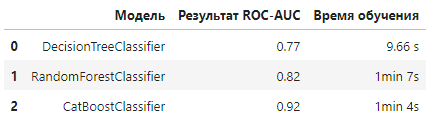

- Проверка качества модели на тестовой выборке показала **ROC-AUC = 0.92**, что лучше требуемого. Дополнительно модель проверена на других метриках, которые показали высокие результаты: качество = 0.94, точность: 0.92.
- Наиболее важными признаками для модели оказались: продолжительность пользования услугами, тип оплаты за услуги (ежемесячный платёж или раз в год, несколько лет) и способ оплаты. Бесполезные: вариант подключения интернет услуг, услуга блокировки небезопасных сайтов и пол клиента.
- Матрица ошибок показала, что модель с высокой вероятностью предсказывала, ушел клиент или нет.
- Из матрицы видно, что 65% клиентов которые модель определит на самом деле собирается уйти и это будет 92% от всех клиентов которые уходят.

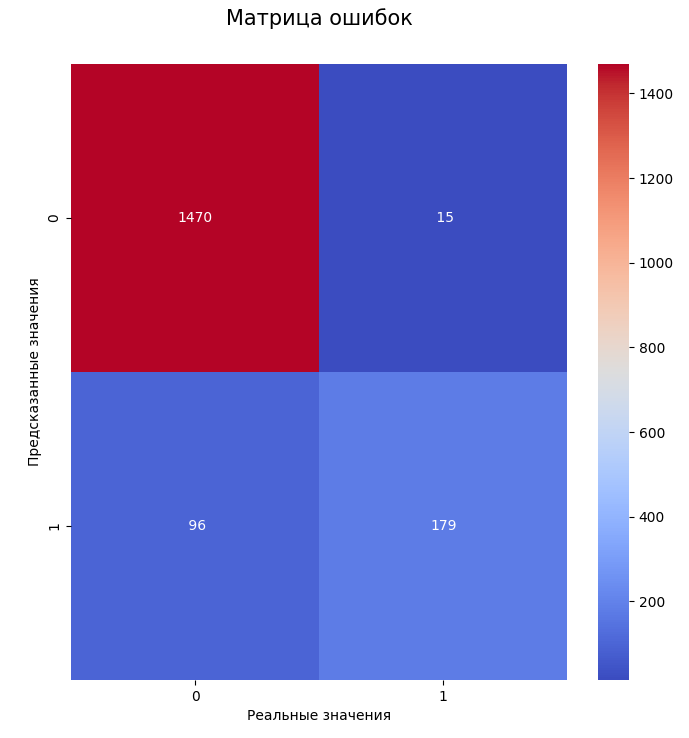

**Заключение: модель CatBoostClassifier с указанными выше гиперпараметрами является наиболее подходящей для прогнозирования оттока клиентов**
